# import libraries

In [21]:
import os
import skimage.io
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import zipfile
import json
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage.transform import resize
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix ,ConfusionMatrixDisplay ,roc_curve, auc , accuracy_score , classification_report
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout ,LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# helpful function

In [2]:
# display some images from the dataset

def draw_func(list_of_imgs, list_of_labels):
    # create figure
    fig = plt.figure(figsize=(10, 7))
    # setting values to rows and column variables
    rows, columns = 3, 3

    # Separate fake and real images based on labels
    fake_images = [img for img, label in zip(list_of_imgs, list_of_labels) if label == 'fake' or 'fake1' or 'fake2' or 'fake3' or 'fake4'or 'fake5'  ]
    real_images = [img for img, label in zip(list_of_imgs, list_of_labels) if label == 'real' or 'real1'or 'real2'or 'real3'or 'real4'or 'real5']

    # Randomly select fake and real images with appropriate sample sizes
    fake_sample_size = min(5, len(fake_images))  # Adjust sample size if fewer than 5 fake images
    real_sample_size = min(4, len(real_images))  # Adjust sample size if fewer than 4 real images
    fake_sample = random.sample(fake_images, fake_sample_size)
    real_sample = random.sample(real_images, real_sample_size)

    # Combine the selected images and labels
    sample_images = fake_sample + real_sample
    sample_labels = ['fake'] * fake_sample_size + ['real'] * real_sample_size

    # Iterate over the selected images and labels
    for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
        # Adds a subplot at the i+1 position
        ax = fig.add_subplot(rows, columns, i+1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)  # Set the title as the corresponding label

    plt.tight_layout()
    plt.show()

In [3]:
# Plot learning curve
def plot_learning_curve(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()

In [4]:
# function for evaluate the modl on test data
threshold = 0.5
def evaluate_test(model):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(x_test , y_test, verbose=0)
    y_test_pred = model.predict(x_test)
    threshold = 0.5
    y_test_pred_binary = (y_test_pred > threshold).astype(int)


    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
    # Generate a classification report
    report = classification_report(y_test, y_test_pred_binary)

    # Print the classification report
    print("\n")
    print("Classification Report:")
    print(report)
    return test_loss, test_accuracy

In [5]:
# function for predict confusion matrix
def prediction_confmatrix(model):
    # Get the predicted labels for training, validation, and test sets
    y_train_pred = model.predict(x_train)
    y_val_pred  = model.predict(x_val)
    y_test_pred = model.predict(x_test)

    threshold = 0.5
    y_train_pred_binary = (y_train_pred > threshold).astype(int)
    y_val_pred_binary = (y_val_pred > threshold).astype(int)
    y_test_pred_binary = (y_test_pred > threshold).astype(int)


    # Compute the confusion matrix for training, validation, and test sets
    train_conf_matrix = confusion_matrix(y_train,y_train_pred_binary)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred_binary)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

        # Set up the plot with a blue color map
    fig, axes = plt.subplots(1, 3, figsize=(16, 6), dpi=100)

    # Plot the confusion matrix for training set
    sns.heatmap(train_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"],
                ax=axes[0])
    axes[0].set(title='Confusion Matrix - Training Set')

    # Print the confusion matrix for training set
    print("Confusion Matrix - Training Set:")
    print(train_conf_matrix)

    # Plot the confusion matrix for validation set
    sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"],
                ax=axes[1])
    axes[1].set(title='Confusion Matrix - Validation Set')

    # Print the confusion matrix for validation set
    print("Confusion Matrix - Validation Set:")
    print(val_conf_matrix)

    # Plot the confusion matrix for test set
    sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"],
                ax=axes[2])
    axes[2].set(title='Confusion Matrix - Test Set')

    # Print the confusion matrix for test set
    print("Confusion Matrix - Test Set:")
    print(test_conf_matrix)

    plt.show()

    return y_train_pred_binary ,y_val_pred_binary, y_test_pred_binary ,train_conf_matrix,val_conf_matrix,test_conf_matrix

In [6]:
# Function to load images and resize them to (128, 128, 3)
def load_images(folder_path, limit=5000):
    images = []
    file_names = os.listdir(folder_path)

    # Ensure we don't exceed the limit
    for i, file_name in enumerate(file_names):
        if i >= limit:
            break
        file_path = os.path.join(folder_path, file_name)
        image = skimage.io.imread(file_path)
        image = resize(image, (128, 128, 3), anti_aliasing=True)
        images.append(image)

    return images

# load dataset

In [7]:
#define path and folders inside it
train_p ='E:\\New folder (6)\\New folder\\train'
test_p ='E:\\New folder (6)\\New folder\\test'
val_p = 'E:\\New folder (6)\\New folder\\valid'
folders = [f for f in os.listdir(train_p)]
print("folders=", folders)

folders= ['fake', 'real']


train data

In [8]:
#load the train data and put it in dataframe
train = pd.DataFrame(columns=['image', 'label'])

for folder in folders:
    images = load_images(os.path.join(train_p, folder))
    train_df = pd.DataFrame({'image': images ,'label': folder})
    train = pd.concat([train_df,train], ignore_index=False)
# Shuffle the data in the DataFrame
train = train.sample(frac=1).reset_index(drop=True)
train.head()

,image,label
0,"[[[0.6459024404375454, 0.38698585047871753, 0....",fake
1,"[[[0.4224169513595476, 0.39913247210426617, 0....",fake
2,"[[[0.5918059369498908, 0.513888755913827, 0.24...",fake
3,"[[[0.9361217120102034, 0.9398330014862392, 0.9...",real
4,"[[[0.3181579437703176, 0.6636980297516356, 0.5...",fake


In [9]:
train

,image,label
0,"[[[0.6459024404375454, 0.38698585047871753, 0....",fake
1,"[[[0.4224169513595476, 0.39913247210426617, 0....",fake
2,"[[[0.5918059369498908, 0.513888755913827, 0.24...",fake
3,"[[[0.9361217120102034, 0.9398330014862392, 0.9...",real
4,"[[[0.3181579437703176, 0.6636980297516356, 0.5...",fake
...,...,...
9995,"[[[0.9116799551022408, 0.9469740727492996, 0.9...",real
9996,"[[[0.9568628005151053, 0.9529412318876543, 0.9...",real
9997,"[[[0.2216679791287588, 0.251161898080549, 0.19...",fake
9998,"[[[0.004387797014020643, 0.004387797014020643,...",fake


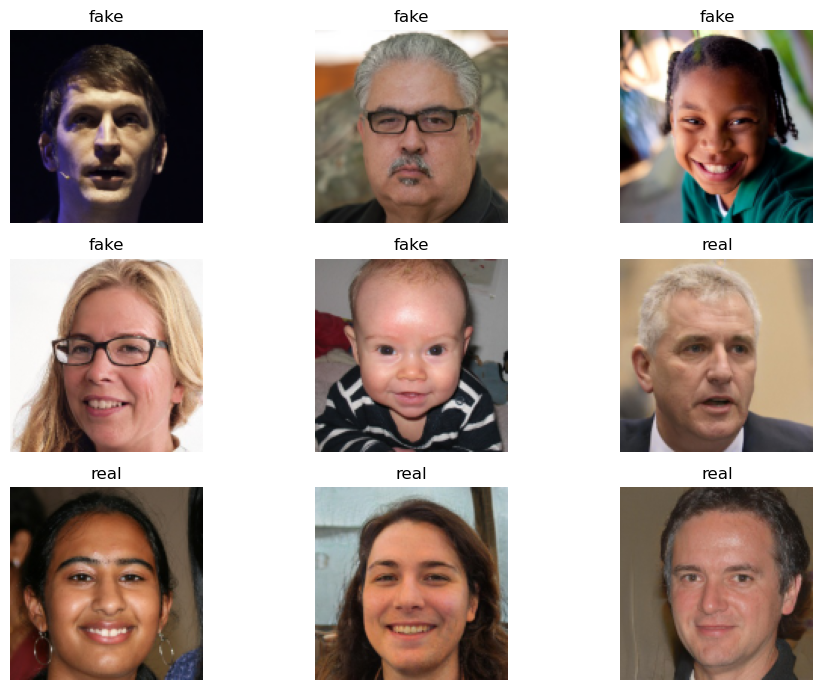

In [10]:
# show images sampels
draw_func(train['image'] ,train['label'])

test data

In [11]:
#load the test data and put it in dataframe
test = pd.DataFrame(columns=['image', 'label'])

for folder in folders:
    images = load_images(os.path.join(test_p, folder))
    test_df = pd.DataFrame({'image': images ,'label': folder})
    test = pd.concat([test_df,test], ignore_index=False)

# Shuffle the data in the DataFrame
test = test.sample(frac=1).reset_index(drop=True)
test


,image,label
0,"[[[0.531944175604883, 0.531944175604883, 0.531...",real
1,"[[[0.22249197241937851, 0.11075510394286639, 0...",fake
2,"[[[0.37547995535821455, 0.31335439168185397, 0...",real
3,"[[[0.86108940573009, 0.7355980643255344, 0.543...",fake
4,"[[[0.5120203133347803, 0.4019704594655905, 0.4...",fake
...,...,...
9995,"[[[0.4862747961695824, 0.6941178779391587, 0.8...",real
9996,"[[[0.0849421945876316, 0.04964979492975904, 0....",fake
9997,"[[[0.021143096338450396, 0.0134127851385256, 0...",real
9998,"[[[0.5906161470260912, 0.6572833310752729, 0.8...",real


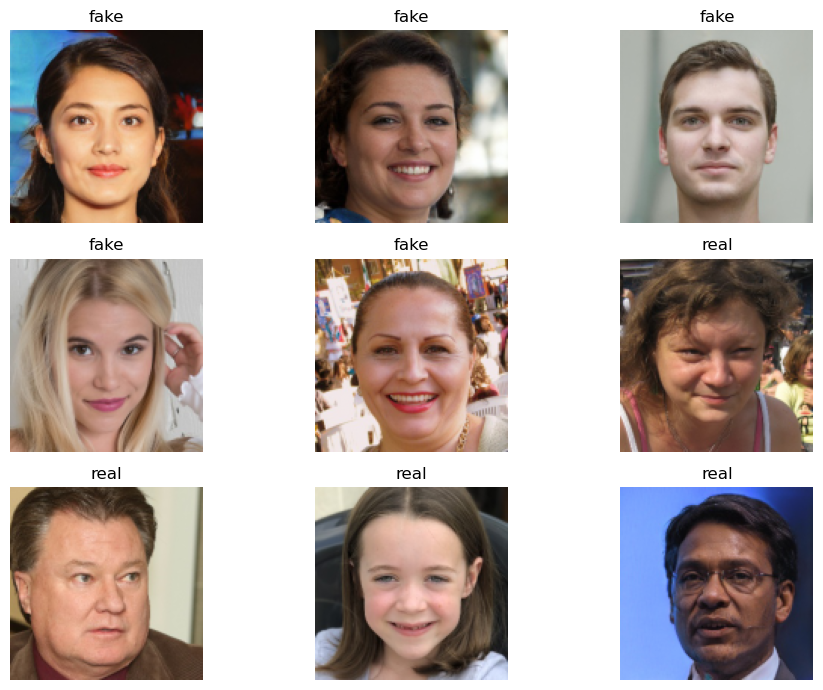

In [12]:
# show images sampels
draw_func(test['image'] ,test['label'])

validation data

In [13]:
#load the val data and put it in dataframe
val = pd.DataFrame(columns=['image', 'label'])

for folder in folders:
    images = load_images(os.path.join(val_p, folder))
    val_df = pd.DataFrame({'image': images ,'label': folder})
    val = pd.concat([val_df,val], ignore_index=False)

# Shuffle the data in the DataFrame
val = val.sample(frac=1).reset_index(drop=True)
val.head()

,image,label
0,"[[[0.8071527994455493, 0.7957861564491178, 0.5...",real
1,"[[[0.3149786282661181, 0.41598651803179554, 0....",fake
2,"[[[0.6664219651740965, 0.6522759445543695, 0.6...",real
3,"[[[0.378684349628125, 0.5940567020730259, 0.27...",fake
4,"[[[0.5183135633689432, 0.5300905239479883, 0.4...",fake


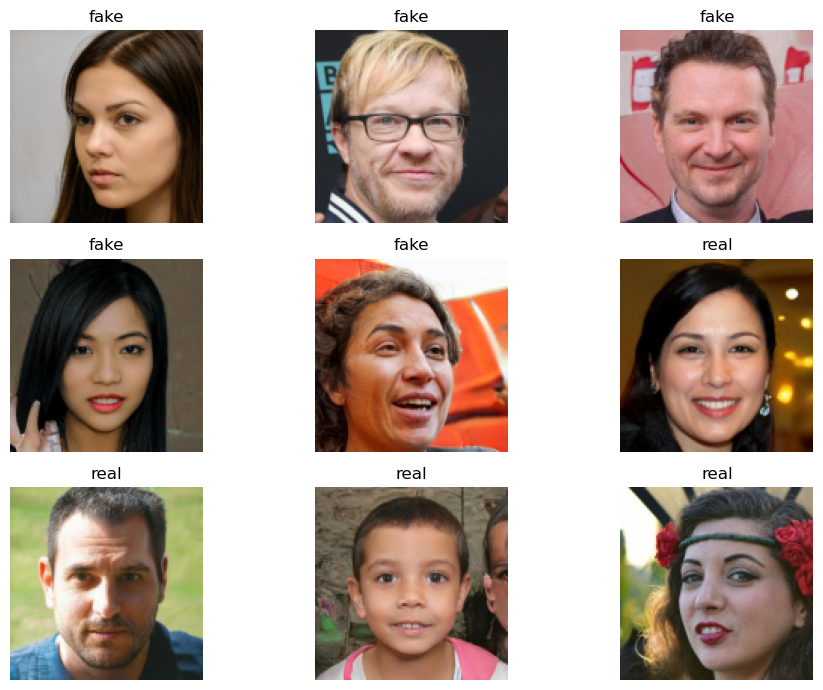

In [14]:
# show images sampels
draw_func(val['image'] ,val['label'])

# preprocess the data

In [15]:
#specify x for (train,val,test) then convert them to np.array to match the model
x_train = train['image']
x_val = val['image']
x_test = test['image']

x_train = np.stack(x_train.values)
x_val = np.stack(x_val.values)
x_test = np.stack(x_test.values)

In [16]:
x_train.shape , x_val.shape  , x_test.shape

((10000, 128, 128, 3), (10000, 128, 128, 3), (10000, 128, 128, 3))

In [17]:
#specify y for (train,val,test) then convert them to categorical to match the model
y_train = train['label']
y_val = val['label']
y_test = test['label']

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train= label_encoder.transform(y_train)

label_encoder.fit(y_val)
y_val= label_encoder.transform(y_val)

label_encoder.fit(y_test)
y_test= label_encoder.transform(y_test)

In [18]:
y_test.shape , y_train.shape  , y_test.shape

((10000,), (10000,), (10000,))

# models

In [19]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

**MobileNetV2**

In [22]:
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model without the top (classification) layers
base_model1 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom top layers for classification
model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(256, activation=LeakyReLU(alpha=0.01)))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,586,177
Trainable params: 2,552,065
Non-trainable params: 34,112
_________________________________________________________________


In [23]:
# Compile the model
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history1 = model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=16, callbacks=[early_stopping])

Epoch 1/20
625/625 [==============================] - 499s 749ms/step - loss: 0.4259 - accuracy: 0.7988 - val_loss: 0.7482 - val_accuracy: 0.7314
Epoch 2/20
625/625 [==============================] - 520s 833ms/step - loss: 0.1946 - accuracy: 0.9221 - val_loss: 0.3758 - val_accuracy: 0.8498
Epoch 3/20
625/625 [==============================] - 474s 759ms/step - loss: 0.1084 - accuracy: 0.9598 - val_loss: 0.4429 - val_accuracy: 0.8753
Epoch 4/20
625/625 [==============================] - 519s 831ms/step - loss: 0.0881 - accuracy: 0.9654 - val_loss: 0.6587 - val_accuracy: 0.8374
Epoch 5/20
625/625 [==============================] - 473s 757ms/step - loss: 0.0818 - accuracy: 0.9690 - val_loss: 0.4215 - val_accuracy: 0.8938
Epoch 6/20
625/625 [==============================] - 524s 838ms/step - loss: 0.0489 - accuracy: 0.9830 - val_loss: 0.4429 - val_accuracy: 0.9010
Epoch 7/20
625/625 [==============================] - 438s 701ms/step - loss: 0.0459 - accuracy: 0.9838 - val_loss: 0.5758 -

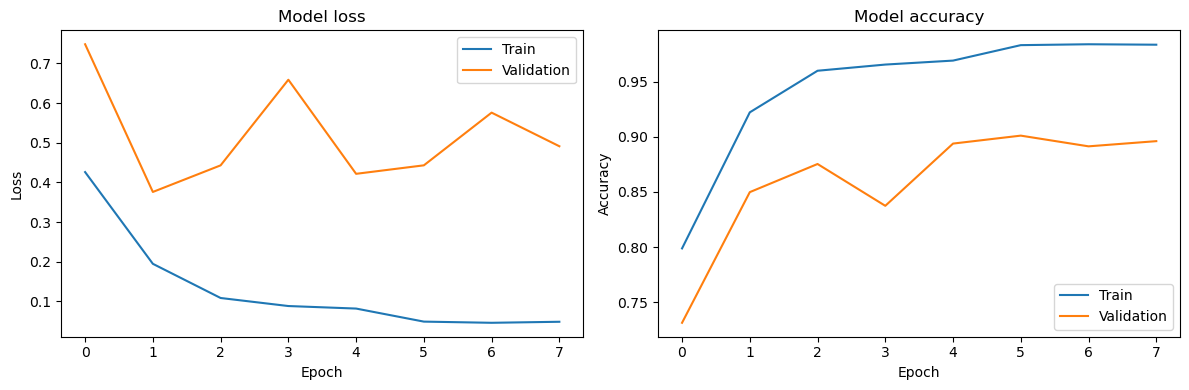

In [24]:
# Plot the learning curve
plot_learning_curve(history1)

In [25]:
# evaluate the model in test data
evaluation1=evaluate_test(model1)

313/313 [==============================] - 66s 203ms/step
Test Loss: 0.3765656054019928
Test Accuracy: 0.8496000170707703
Test Accuracy: 84.96%


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      5000
           1       0.80      0.93      0.86      5000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



313/313 [==============================] - 68s 216ms/step
Confusion Matrix - Training Set:
[[4178  822]
 [ 176 4824]]
Confusion Matrix - Validation Set:
[[3835 1165]
 [ 337 4663]]
Confusion Matrix - Test Set:
[[3838 1162]
 [ 342 4658]]


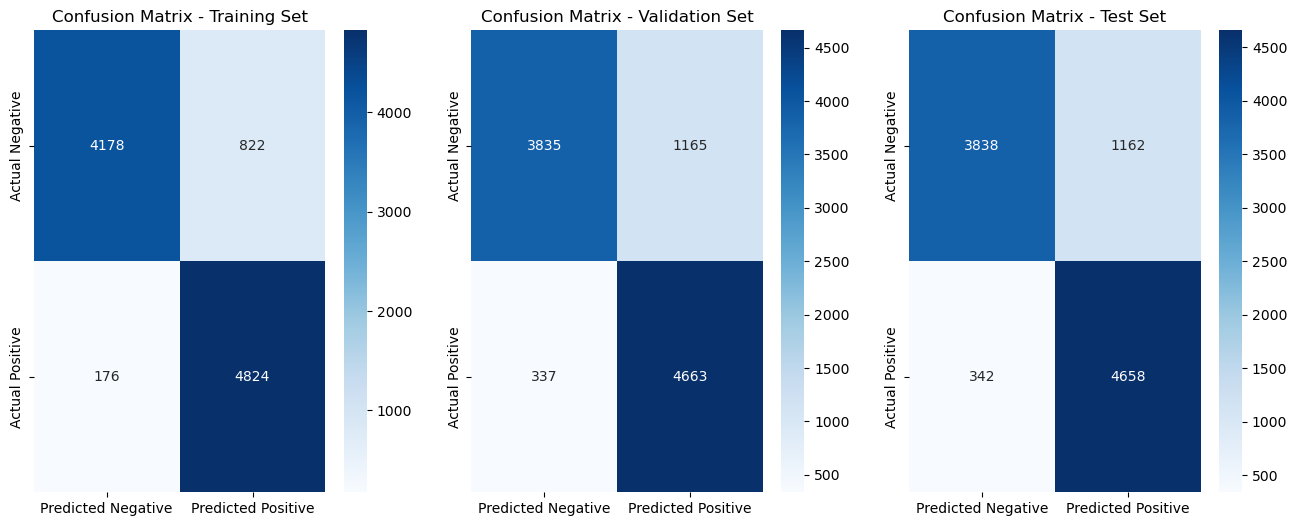

In [26]:
# predict values and confusion matrix
prediction1=prediction_confmatrix(model1)

**ResNet50**

In [27]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [28]:
# Load the ResNet50 model without the top (classification) layers
base_model2 = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom top layers for classification
model2 = Sequential()
model2.add(base_model2)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256, activation=LeakyReLU(alpha=0.01)))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,112,513
Trainable params: 24,059,393
Non-trainable params: 53,120
_________________________________________________________________


In [29]:

# Compile the model
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=16, callbacks=[early_stopping])

Epoch 1/20
625/625 [==============================] - 870s 1s/step - loss: 0.3918 - accuracy: 0.8220 - val_loss: 1.1900 - val_accuracy: 0.5275
Epoch 2/20
625/625 [==============================] - 671s 1s/step - loss: 0.1490 - accuracy: 0.9445 - val_loss: 0.2627 - val_accuracy: 0.8996
Epoch 3/20
625/625 [==============================] - 669s 1s/step - loss: 0.0836 - accuracy: 0.9671 - val_loss: 0.2863 - val_accuracy: 0.9052
Epoch 4/20
625/625 [==============================] - 672s 1s/step - loss: 0.0645 - accuracy: 0.9783 - val_loss: 0.2187 - val_accuracy: 0.9185
Epoch 5/20
625/625 [==============================] - 668s 1s/step - loss: 0.0569 - accuracy: 0.9803 - val_loss: 0.2034 - val_accuracy: 0.9253
Epoch 6/20
625/625 [==============================] - 669s 1s/step - loss: 0.0336 - accuracy: 0.9880 - val_loss: 0.2181 - val_accuracy: 0.9238
Epoch 7/20
625/625 [==============================] - 670s 1s/step - loss: 0.0370 - accuracy: 0.9878 - val_loss: 0.2209 - val_accuracy: 0.9260

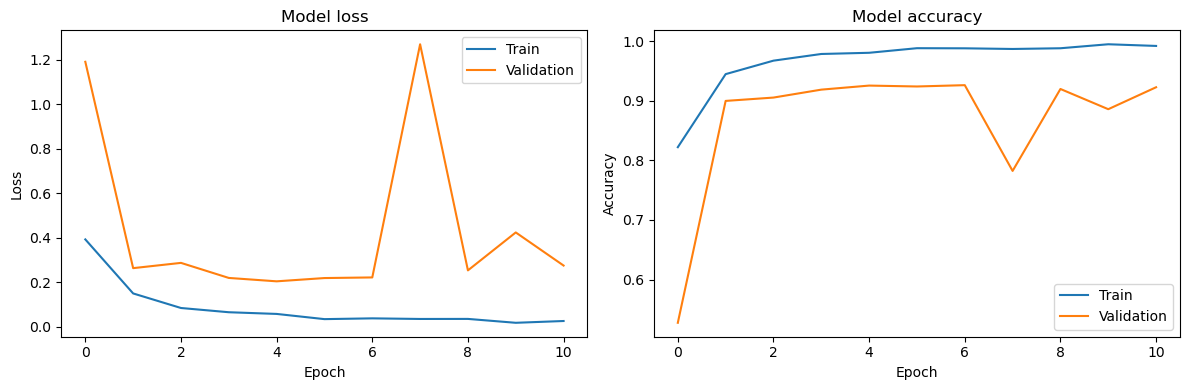

In [30]:
# Plot the learning curve
plot_learning_curve(history2)

In [31]:
# evaluate the model in test data
evaluation2=evaluate_test(model2)

313/313 [==============================] - 108s 341ms/step
Test Loss: 0.20516015589237213
Test Accuracy: 0.92330002784729
Test Accuracy: 92.33%


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      5000
           1       0.91      0.94      0.92      5000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



313/313 [==============================] - 105s 336ms/step
Confusion Matrix - Training Set:
[[4945   55]
 [  56 4944]]
Confusion Matrix - Validation Set:
[[4581  419]
 [ 328 4672]]
Confusion Matrix - Test Set:
[[4549  451]
 [ 316 4684]]


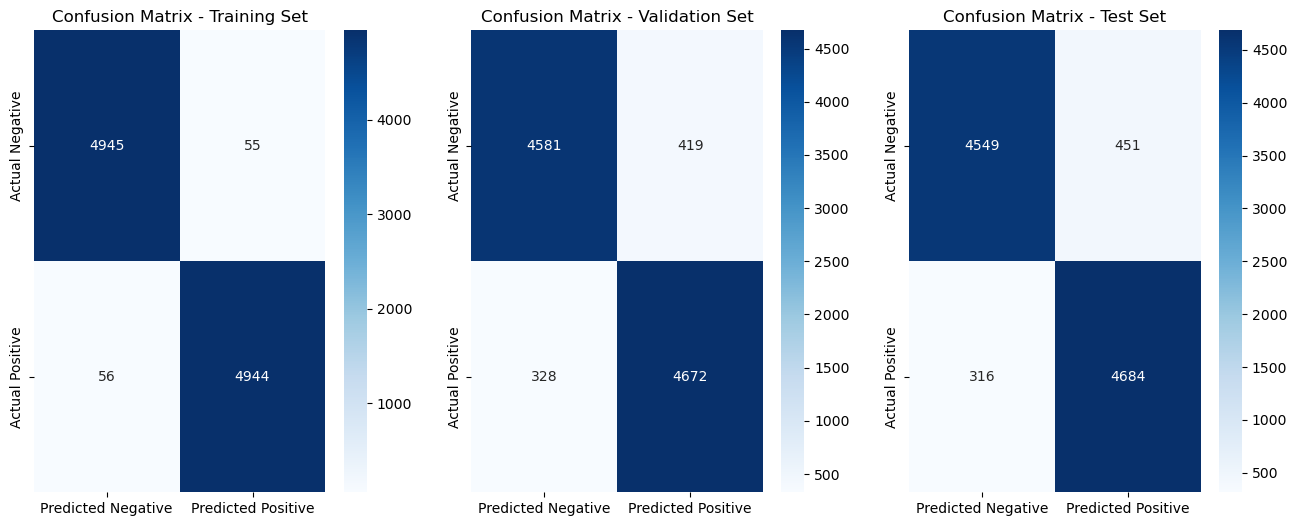

In [32]:
# predict values and confusion matrix
prediction2=prediction_confmatrix(model2)

**VGG16**

In [40]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [41]:
# Load the VGG16 model without the top (classification) layers
base_model3 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom top layers for classification
model3 = Sequential()
model3.add(base_model3)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(256, activation=LeakyReLU(alpha=0.01)))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


In [42]:

# Compile the model
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=16, callbacks=[early_stopping])


Epoch 1/20
625/625 [==============================] - 1977s 3s/step - loss: 0.6821 - accuracy: 0.5384 - val_loss: 0.5683 - val_accuracy: 0.7053
Epoch 2/20
625/625 [==============================] - 1990s 3s/step - loss: 0.5029 - accuracy: 0.7546 - val_loss: 0.4183 - val_accuracy: 0.8157
Epoch 3/20
625/625 [==============================] - 1998s 3s/step - loss: 0.3227 - accuracy: 0.8615 - val_loss: 0.2879 - val_accuracy: 0.8766
Epoch 4/20
625/625 [==============================] - 1995s 3s/step - loss: 0.1889 - accuracy: 0.9249 - val_loss: 0.2400 - val_accuracy: 0.9013
Epoch 5/20
625/625 [==============================] - 1989s 3s/step - loss: 0.1152 - accuracy: 0.9566 - val_loss: 0.2501 - val_accuracy: 0.9073
Epoch 6/20
625/625 [==============================] - 1993s 3s/step - loss: 0.0690 - accuracy: 0.9727 - val_loss: 0.2442 - val_accuracy: 0.9102
Epoch 7/20
625/625 [==============================] - 1991s 3s/step - loss: 0.0437 - accuracy: 0.9829 - val_loss: 0.2641 - val_accuracy:

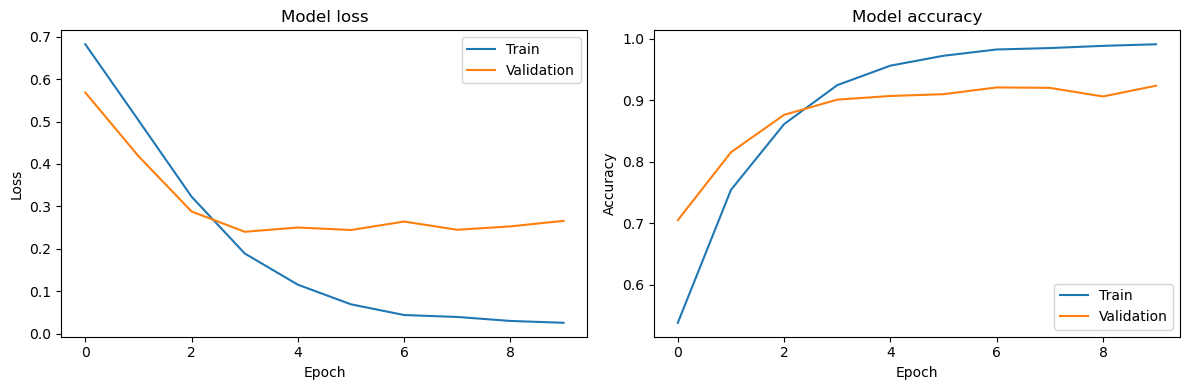

In [43]:
# Plot the learning curve
plot_learning_curve(history3)

In [44]:
# evaluate the model in test data
evaluation3=evaluate_test(model3)

313/313 [==============================] - 325s 1s/step
Test Loss: 0.23895695805549622
Test Accuracy: 0.901199996471405
Test Accuracy: 90.12%


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      5000
           1       0.87      0.94      0.91      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



313/313 [==============================] - 325s 1s/step
Confusion Matrix - Training Set:
[[4730  270]
 [  54 4946]]
Confusion Matrix - Validation Set:
[[4312  688]
 [ 299 4701]]
Confusion Matrix - Test Set:
[[4296  704]
 [ 284 4716]]


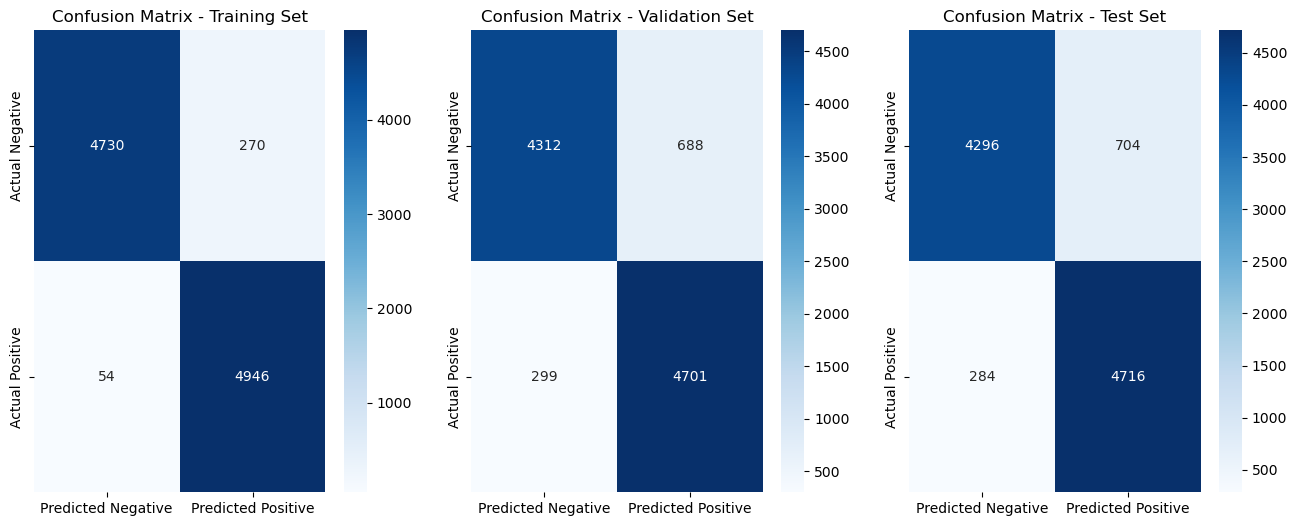

In [45]:
# predict values and confusion matrix
prediction3=prediction_confmatrix(model3)

comparison

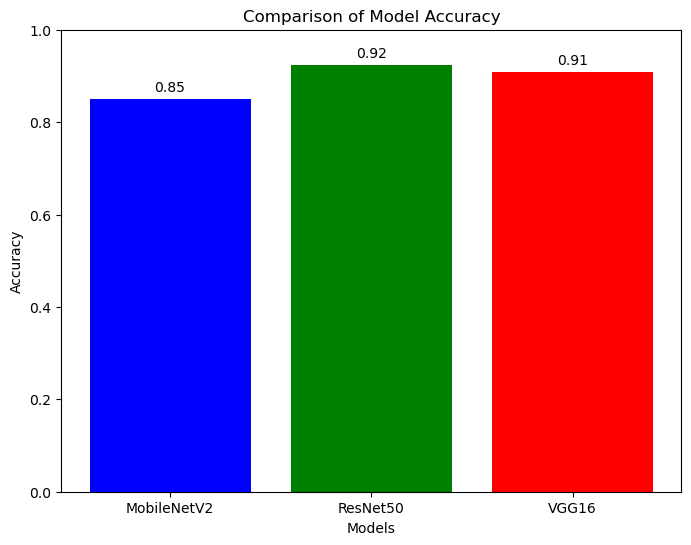

In [39]:

# Sample data for three models
models = ['MobileNetV2', 'ResNet50', 'VGG16']
accuracy = [evaluation1[1],evaluation2[1],evaluation3[1]]

# Bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracy, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy')
plt.ylim(0, 1)  # Set y-axis range if needed

# Display the values on top of the bars
for i, value in enumerate(accuracy):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()


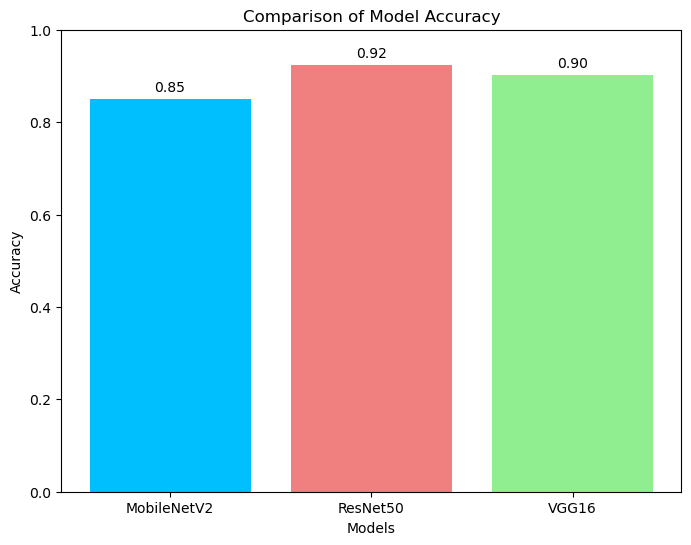

In [46]:

# Sample data for three models
models = ['MobileNetV2', 'ResNet50', 'VGG16']
accuracy = [evaluation1[1],evaluation2[1],evaluation3[1]]

# Bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracy, color=['deepskyblue','lightcoral', 'lightgreen' ])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy')
plt.ylim(0, 1)  # Set y-axis range if needed

# Display the values on top of the bars
for i, value in enumerate(accuracy):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()
